In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/archive (1).zip" -d "/content/dataset/"

Archive:  /content/gdrive/MyDrive/archive (1).zip
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/0.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/1.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/10.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/100.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/101.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/102.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/103.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/104.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/105.jpg  
  inflating: /content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database/Cyclone/106.jpg  
  inflating: /content/dataset/Cyclone_Wildfir

In [3]:
import os
DATASET_PATH = "/content/dataset/Cyclone_Wildfire_Flood_Earthquake_Database"
CLASSES = ["Cyclone", "Earthquake", "Flood", "Wildfire"]

In [4]:
# define the size of the training, validation (which comes from the
# train split), and testing splits, respectively
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.1
TEST_SPLIT = 0.25

In [5]:
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-6
MAX_LR = 1e-4
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48

In [6]:
# set the path to the serialized model after training
MODEL_PATH = os.path.sep.join(["output", "natural_disaster.model"])
# define the path to the output learning rate finder plot, training
# history plot and cyclical learning rate plot
LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["output", "clr_plot.png"])

In [7]:
# import the necessary packages
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
    # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
    def is_data_iter(self, data):
        # define the set of class types we will check for
        iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
             "DataFrameIterator", "Iterator", "Sequence"]
        # return whether our data is an iterator
        return data.__class__.__name__ in iterClasses
    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
    def find(self, trainData, startLR, endLR, epochs=None,
        stepsPerEpoch=None, batchSize=32, sampleSize=2048,
        verbose=1):
        # reset our class-specific variables
        self.reset()
        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)
        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)
        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)
        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        # check to see if we are using a data iterator
        if useGen:
            self.model.fit(
                x=trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])
        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                x=trainData[0], y=trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)
        def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
            lrs = self.lrs[skipBegin:-skipEnd]
            losses = self.losses[skipBegin:-skipEnd]
            # plot the learning rate vs. loss
            plt.plot(lrs, losses)
            plt.xscale("log")
            plt.xlabel("Learning Rate (Log Scale)")
            plt.ylabel("Loss")
            # if the title is not empty, add it to the plot
            if title != "":
                plt.title(title)

In [8]:
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import numpy as np

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [9]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import sys
import os

In [10]:
imagePaths = list(paths.list_images(DATASET_PATH))
data = []
labels = []

In [11]:
# loop over the image paths
for imagePath in imagePaths:
    # extract the class label
    label = imagePath.split(os.path.sep)[-2]
    # load the image, convert it to RGB channel ordering, and resize
    # it to be a fixed 224x224 pixels, ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
# convert the data and labels to NumPy arrays
print("[INFO] processing data...")
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

[INFO] processing data...


In [12]:
# partition the data into training and testing splits
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=TEST_SPLIT, random_state=42)
# take the validation split from the training split
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY,
    test_size=VAL_SPLIT, random_state=84)
# initialize the training data augmentation object
aug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [13]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(CLASSES), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = SGD(lr=MIN_LR, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

58892288/58889256 [==============================] - 0s 0us/step
[INFO] compiling model...


In [14]:
print("[INFO] finding learning rate...")
lrf = LearningRateFinder(model)
lrf.find(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    1e-10, 1e+1,
    stepsPerEpoch=np.ceil((trainX.shape[0] / float(BATCH_SIZE))),
    epochs=20,
    batchSize=BATCH_SIZE)
 
# plot the loss for the various learning rates and save the
# resulting plot to disk
 
# gracefully exit the script so we can adjust our learning rates
# in the config and then train the network for our full set of
# epochs
print("[INFO] learning rate finder complete")
print("[INFO] examine plot and adjust learning rates before training")

[INFO] finding learning rate...
Epoch 1/20
94/94 [==============================] - 40s 338ms/step - loss: 16.3171 - accuracy: 0.2589
Epoch 2/20
94/94 [==============================] - 32s 336ms/step - loss: 16.1367 - accuracy: 0.2683
Epoch 3/20
94/94 [==============================] - 32s 337ms/step - loss: 16.1155 - accuracy: 0.2526
Epoch 4/20
94/94 [==============================] - 31s 334ms/step - loss: 16.1135 - accuracy: 0.2481
Epoch 5/20
94/94 [==============================] - 32s 335ms/step - loss: 16.0180 - accuracy: 0.2430
Epoch 6/20
94/94 [==============================] - 32s 336ms/step - loss: 16.2757 - accuracy: 0.2689
Epoch 7/20
94/94 [==============================] - 32s 336ms/step - loss: 14.3338 - accuracy: 0.2705
Epoch 8/20
94/94 [==============================] - 31s 334ms/step - loss: 12.5347 - accuracy: 0.3452
Epoch 9/20
94/94 [==============================] - 32s 336ms/step - loss: 8.7940 - accuracy: 0.4594
Epoch 10/20
94/94 [==============================] 

In [15]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=stepSize)
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(valX, valY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)

[INFO] training network...


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/48
93/93 [==============================] - 34s 365ms/step - loss: 18915.2520 - accuracy: 0.3769 - val_loss: 345.4855 - val_accuracy: 0.6697
Epoch 2/48
93/93 [==============================] - 33s 350ms/step - loss: 146.8251 - accuracy: 0.6976 - val_loss: 41.8224 - val_accuracy: 0.8258
Epoch 3/48
93/93 [==============================] - 32s 349ms/step - loss: 54.1290 - accuracy: 0.7940 - val_loss: 5.3081 - val_accuracy: 0.8498
Epoch 4/48
93/93 [==============================] - 33s 351ms/step - loss: 27.7201 - accuracy: 0.8254 - val_loss: 6.1894 - val_accuracy: 0.8589
Epoch 5/48
93/93 [==============================] - 32s 348ms/step - loss: 7.6618 - accuracy: 0.8383 - val_loss: 105.7564 - val_accuracy: 0.8048
Epoch 6/48
93/93 [==============================] - 32s 348ms/step - loss: 6.6222 - accuracy: 0.8488 - val_loss: 0.8766 - val_accuracy: 0.9009
Epoch 7/48
93/93 [==============================] - 33s 350ms/step - loss: 4.2949 - accuracy: 0.8440 - val_loss: 6.3201 - val_acc

In [16]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))
# serialize the model to disk
print("[INFO] serializing network to '{}'...".format(MODEL_PATH))
model.save(MODEL_PATH)

[INFO] evaluating network...
              precision    recall  f1-score   support

     Cyclone       0.96      0.97      0.96       205
  Earthquake       0.96      0.92      0.94       362
       Flood       0.89      0.91      0.90       267
    Wildfire       0.94      0.97      0.95       273

    accuracy                           0.94      1107
   macro avg       0.94      0.94      0.94      1107
weighted avg       0.94      0.94      0.94      1107

[INFO] serializing network to 'output/natural_disaster.model'...
INFO:tensorflow:Assets written to: output/natural_disaster.model/assets


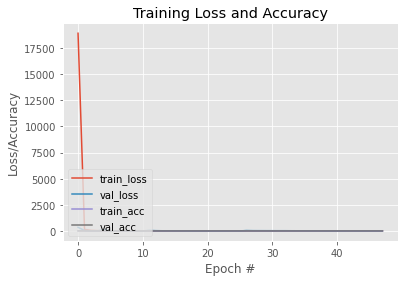

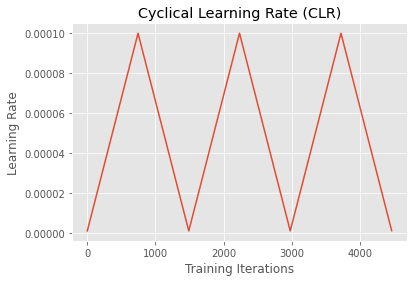

In [25]:
# construct a plot that plots and saves the training history
%matplotlib inline
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(TRAINING_PLOT_PATH)
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure()
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.show()